In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from category_encoders import OneHotEncoder, MEstimateEncoder, GLMMEncoder, OrdinalEncoder, CatBoostEncoder

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

In [ ]:
'''
12가지 특성을 기반으로 기계 고장을 예측하는 것이 우리의 과제입니다:

제품 ID: 각 기계의 고유 ID
유형: 크기에 따라 큰 기계 (L), 중간 크기의 기계 (M) 및 작은 기계 (S)로 나뉩니다.
공기 온도: 켈빈 단위의 공기 온도
프로세스 온도: 켈빈 단위의 기계 작업 중 온도
토크: 뉴턴·미터 단위의 회전력
회전 속도: 초당 회전 빈도
공구 마모: 분 단위의 기계 사용 시간
TWF: 공구 마모 고장
HDF: 열 방출 고장
PWF: 전원 고장
OSF: 과부하 고장
RNF: 무작위 고장
TWF, HDF, PWF, OSF 및 RNF은 기계가 나타낼 수 있는 고장 유형입니다.
'''

In [16]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
machine_failure = pd.read_csv('machine failure.csv')

In [17]:
df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [5]:
test.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [13]:
machine_failure.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [18]:
'''
axis=1은 열을 나타내며, axis=0은 행을 나타냅니다. 
기본적으로 inplace=False로 설정되어 있으며 원본 데이터프레임은 변경되지 않습니다.
'''
df.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)
machine_failure.drop('UDI', axis=1, inplace=True)

In [19]:
desc = pd.DataFrame(index = list(df))
desc['count'] = df.count()
desc['nunique'] = df.nunique()
desc['%unique'] = desc['nunique'] / len(df) * 100
desc['null'] = df.isnull().sum()
desc['type'] = df.dtypes
desc = pd.concat([desc, df.describe().T.drop('count', axis = 1)], axis = 1)
desc

,count,nunique,%unique,null,type,mean,std,min,25%,50%,75%,max
Product ID,136429,9976,7.312228,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,136429,3,0.002199,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Air temperature [K],136429,95,0.069633,0,float64,299.862776,1.862247,295.3,298.3,300.0,301.2,304.4
Process temperature [K],136429,81,0.059372,0,float64,309.941070,1.385173,305.8,308.7,310.0,310.9,313.8
Rotational speed [rpm],136429,952,0.697799,0,int64,1520.331110,138.736632,1181.0,1432.0,1493.0,1580.0,2886.0
Torque [Nm],136429,611,0.447852,0,float64,40.348643,8.502229,3.8,34.6,40.4,46.1,76.6
Tool wear [min],136429,246,0.180314,0,int64,104.408901,63.965040,0.0,48.0,106.0,159.0,253.0
Machine failure,136429,2,0.001466,0,int64,0.015744,0.124486,0.0,0.0,0.0,0.0,1.0
TWF,136429,2,0.001466,0,int64,0.001554,0.039389,0.0,0.0,0.0,0.0,1.0
HDF,136429,2,0.001466,0,int64,0.005160,0.071649,0.0,0.0,0.0,0.0,1.0


In [9]:
desc = pd.DataFrame(index = list(test))
desc['count'] = test.count()
desc['nunique'] = test.nunique()
desc['%unique'] = desc['nunique'] / len(test) * 100
desc['null'] = test.isnull().sum()
desc['type'] = test.dtypes
desc = pd.concat([desc, test.describe().T.drop('count', axis = 1)], axis = 1)
desc

,count,nunique,%unique,null,type,mean,std,min,25%,50%,75%,max
Product ID,90954,9909,10.894518,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,90954,3,0.003298,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Air temperature [K],90954,92,0.101150,0,float64,299.859493,1.857562,295.3,298.3,300.0,301.2,304.4
Process temperature [K],90954,84,0.092354,0,float64,309.939375,1.385296,305.7,308.7,310.0,310.9,313.8
Rotational speed [rpm],90954,946,1.040086,0,int64,1520.528179,139.970419,1168.0,1432.0,1493.0,1579.0,2886.0
Torque [Nm],90954,595,0.654177,0,float64,40.335191,8.504683,3.8,34.6,40.5,46.2,76.6
Tool wear [min],90954,246,0.270466,0,int64,104.293962,63.871092,0.0,48.0,106.0,158.0,253.0
TWF,90954,2,0.002199,0,int64,0.001473,0.038355,0.0,0.0,0.0,0.0,1.0
HDF,90954,2,0.002199,0,int64,0.005343,0.072903,0.0,0.0,0.0,0.0,1.0
PWF,90954,2,0.002199,0,int64,0.002353,0.048449,0.0,0.0,0.0,0.0,1.0


In [21]:
desc = pd.DataFrame(index = list(machine_failure))
desc['count'] = machine_failure.count()
desc['nunique'] = machine_failure.nunique()
desc['%unique'] = desc['nunique'] / len(machine_failure) * 100
desc['null'] = machine_failure.isnull().sum()
desc['type'] = machine_failure.dtypes
desc = pd.concat([desc, machine_failure.describe().T.drop('count', axis = 1)], axis = 1)
desc

,count,nunique,%unique,null,type,mean,std,min,25%,50%,75%,max
Product ID,10000,10000,100.00,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,10000,3,0.03,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Air temperature [K],10000,93,0.93,0,float64,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
Process temperature [K],10000,82,0.82,0,float64,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
Rotational speed [rpm],10000,941,9.41,0,int64,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
Torque [Nm],10000,577,5.77,0,float64,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
Tool wear [min],10000,246,2.46,0,int64,107.95100,63.654147,0.0,53.0,108.0,162.0,253.0
Machine failure,10000,2,0.02,0,int64,0.03390,0.180981,0.0,0.0,0.0,0.0,1.0
TWF,10000,2,0.02,0,int64,0.00460,0.067671,0.0,0.0,0.0,0.0,1.0
HDF,10000,2,0.02,0,int64,0.01150,0.106625,0.0,0.0,0.0,0.0,1.0


In [22]:
df.corr().style.background_gradient(cmap='Reds')

C:\Users\csjty\AppData\Local\Temp\ipykernel_25716\3686770038.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().style.background_gradient(cmap='Reds')


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
Air temperature [K],1.000000,0.856080,0.016545,-0.006773,0.016994,0.067744,0.003826,0.100454,0.007967,0.007842,0.004815
Process temperature [K],0.856080,1.000000,0.011263,-0.006298,0.012777,0.030966,0.004459,0.041454,0.003871,0.005337,0.004399
Rotational speed [rpm],0.016545,0.011263,1.000000,-0.779394,0.003983,-0.060868,-0.005765,-0.081996,0.053948,-0.061376,-0.003410
Torque [Nm],-0.006773,-0.006298,-0.779394,1.000000,-0.003148,0.145793,0.012983,0.100773,0.050289,0.108765,0.007986
Tool wear [min],0.016994,0.012777,0.003983,-0.003148,1.000000,0.056448,0.046470,0.011709,0.007624,0.063604,-0.002071
Machine failure,0.067744,0.030966,-0.060868,0.145793,0.056448,1.000000,0.311919,0.564507,0.383941,0.494668,0.001428
TWF,0.003826,0.004459,-0.005765,0.012983,0.046470,0.311919,1.000000,0.010145,0.039927,0.036041,0.002044
HDF,0.100454,0.041454,-0.081996,0.100773,0.011709,0.564507,0.010145,1.000000,0.046680,0.067149,0.000885
PWF,0.007967,0.003871,0.053948,0.050289,0.007624,0.383941,0.039927,0.046680,1.000000,0.090016,0.000827
OSF,0.007842,0.005337,-0.061376,0.108765,0.063604,0.494668,0.036041,0.067149,0.090016,1.000000,-0.000539


In [23]:
test.corr().style.background_gradient(cmap='Reds')

C:\Users\csjty\AppData\Local\Temp\ipykernel_25716\2233054574.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  test.corr().style.background_gradient(cmap='Reds')


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
Air temperature [K],1.000000,0.855972,0.012901,-0.004892,0.018447,0.008893,0.103498,0.003869,0.012608,0.001752
Process temperature [K],0.855972,1.000000,0.008324,-0.006220,0.014616,0.009710,0.043706,-0.002658,0.012992,0.006868
Rotational speed [rpm],0.012901,0.008324,1.000000,-0.777272,0.008849,-0.009013,-0.087204,0.050574,-0.061990,-0.001525
Torque [Nm],-0.004892,-0.006220,-0.777272,1.000000,-0.004352,0.018059,0.103822,0.049382,0.109182,0.002807
Tool wear [min],0.018447,0.014616,0.008849,-0.004352,1.000000,0.043164,0.002014,0.002967,0.066720,-0.002936
TWF,0.008893,0.009710,-0.009013,0.018059,0.043164,1.000000,0.008981,0.033634,0.057624,0.004125
HDF,0.103498,0.043706,-0.087204,0.103822,0.002014,0.008981,1.000000,0.027568,0.053726,0.002759
PWF,0.003869,-0.002658,0.050574,0.049382,0.002967,0.033634,0.027568,1.000000,0.095655,0.002392
OSF,0.012608,0.012992,-0.061990,0.109182,0.066720,0.057624,0.053726,0.095655,1.000000,-0.002998
RNF,0.001752,0.006868,-0.001525,0.002807,-0.002936,0.004125,0.002759,0.002392,-0.002998,1.000000


In [24]:
machine_failure.corr().style.background_gradient(cmap='Reds')

C:\Users\csjty\AppData\Local\Temp\ipykernel_25716\1154765874.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  machine_failure.corr().style.background_gradient(cmap='Reds')


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
Air temperature [K],1.000000,0.876107,0.022670,-0.013778,0.013853,0.082556,0.009955,0.137831,0.003470,0.001988,0.017688
Process temperature [K],0.876107,1.000000,0.019277,-0.014061,0.013488,0.035946,0.007315,0.056933,-0.003355,0.004554,0.022279
Rotational speed [rpm],0.022670,0.019277,1.000000,-0.875027,0.000223,-0.044188,0.010389,-0.121241,0.123018,-0.104575,-0.013088
Torque [Nm],-0.013778,-0.014061,-0.875027,1.000000,-0.003093,0.191321,-0.014662,0.142610,0.083781,0.183465,0.016136
Tool wear [min],0.013853,0.013488,0.000223,-0.003093,1.000000,0.105448,0.115792,-0.001287,-0.009334,0.155894,0.011326
Machine failure,0.082556,0.035946,-0.044188,0.191321,0.105448,1.000000,0.362904,0.575800,0.522812,0.531083,0.004516
TWF,0.009955,0.007315,0.010389,-0.014662,0.115792,0.362904,1.000000,-0.007332,0.008577,0.038243,0.030970
HDF,0.137831,0.056933,-0.121241,0.142610,-0.001287,0.575800,-0.007332,1.000000,0.018443,0.046396,-0.004706
PWF,0.003470,-0.003355,0.123018,0.083781,-0.009334,0.522812,0.008577,0.018443,1.000000,0.115836,-0.004273
OSF,0.001988,0.004554,-0.104575,0.183465,0.155894,0.531083,0.038243,0.046396,0.115836,1.000000,-0.004341


In [26]:
'''
범주형 특성들 제거
'''
categorical_features = ['Product ID', 'Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
numerical_features = test.drop(categorical_features, axis=1).columns
numerical_features

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype='object')

In [30]:
'''
기계의 특성이나 유형을 나타내는 정보를 가지고 있는 'Product ID'와 'Type' 열을 
CatBoostEncoder를 사용하여 인코딩하고
인코딩된 결과는 학습 데이터셋, 검증 데이터셋, 테스트 데이터셋에 적용

'Machine failure'은 타겟 변수로 사용되며, 
이를 통해 CatBoostEncoder가 범주형 변수를 인코딩하는 데 사용된다.

타겟 변수 지정 기준
스팸 메일 분류 문제에서는 이메일이 스팸인지 아닌지를 판별하는 이진 분류 문제로 정의될 수 있습니다. 
이때, 스팸 메일인 경우를 1로, 아닌 경우를 0으로 표현하여 타겟 변수로 사용할 수 있습니다.
회귀 문제에서는 타겟 변수가 예측하고자 하는 수치 값을 나타냅니다. 
예를 들어, 집 가격 예측 문제에서는 각 집의 가격을 타겟 변수로 사용할 수 있습니다. 
이 경우, 각 집의 특성을 기반으로 가격을 예측하는 회귀 모델을 학습할 수 있습니다.

fit_transform 메서드는 주어진 데이터를 학습하여 인코딩된 결과를 반환하는 과정을 수행
모델 학습 시에는 가능한 미래 데이터에 대한 정보를 사용하지 않는 것이 중요합니다. 
따라서, 테스트 데이터에 대해 fit_transform을 수행하는 것은 데이터 누설의 위험이 있습니다. 
학습 데이터로부터 학습된 인코딩 모델을 사용하여 테스트 데이터를 변환할 때에는 transform 메서드를 사용합니다.

'''
cb_enc = CatBoostEncoder(cols=['Product ID', 'Type'])

encoded_train = cb_enc.fit_transform(df.drop('Machine failure', axis=1), df['Machine failure'])
encoded_machine_failure = cb_enc.transform(machine_failure.drop('Machine failure', axis=1))
encoded_test = cb_enc.transform(test)

In [32]:
encoded_train.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,0.015744,0.015744,300.6,309.6,1596,36.1,140,0,0,0,0,0
1,0.015744,0.015744,302.6,312.1,1759,29.1,200,0,0,0,0,0
2,0.015744,0.007872,299.3,308.5,1805,26.5,25,0,0,0,0,0
3,0.015744,0.005248,301.0,310.9,1524,44.3,197,0,0,0,0,0
4,0.015744,0.007872,298.0,309.0,1641,35.4,34,0,0,0,0,0


In [33]:
encoded_train = pd.concat([encoded_train, df['Machine failure']], axis=1)
encoded_machine_failure = pd.concat([encoded_machine_failure, machine_failure['Machine failure']], axis=1)

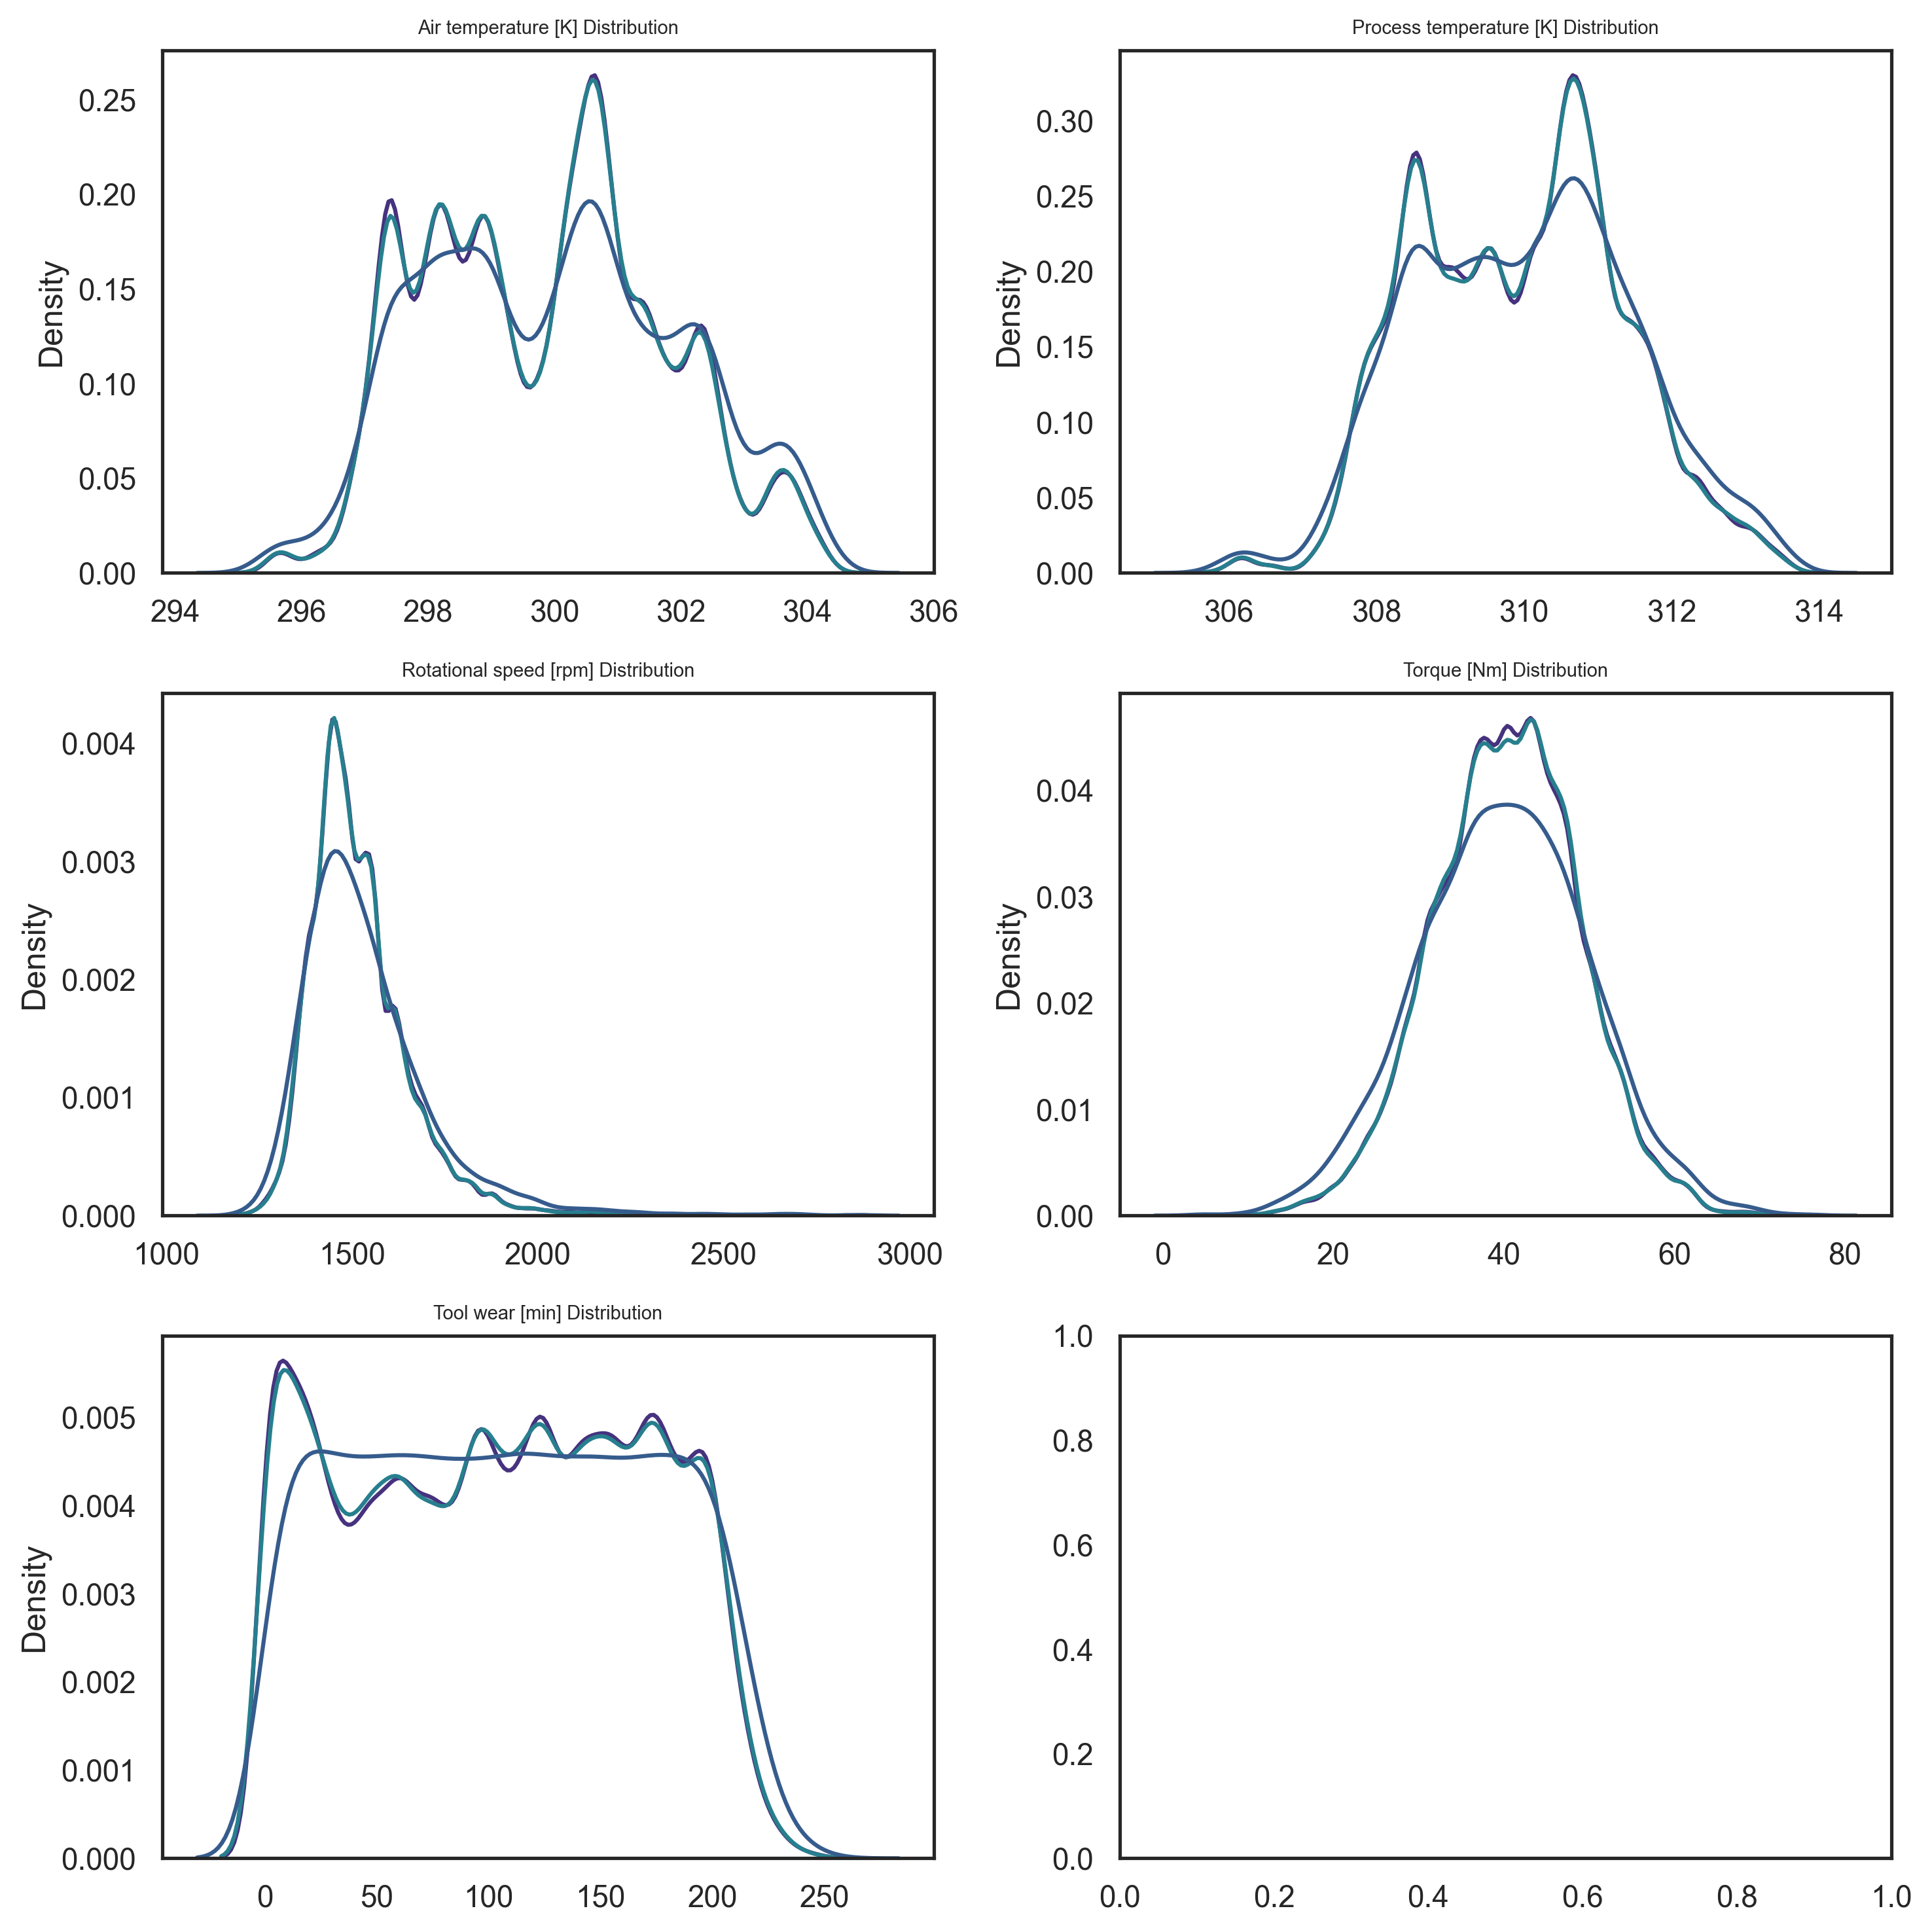

In [37]:
fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=300)
ax = ax.flatten()

for i, column in enumerate(numerical_features):
    sns.kdeplot(encoded_train[column], ax=ax[i], color=pal[0])
    sns.kdeplot(encoded_test[column], ax=ax[i], color=pal[2])
    sns.kdeplot(encoded_machine_failure[column], ax=ax[i], color=pal[1])
    
    ax[i].set_title(f'{column} Distribution', size=7)
    ax[i].set_xlabel(None)
plt.tight_layout()

In [38]:
'''
주요 포인트:

모든 수치형 특성은 학습 및 테스트 데이터셋 간에 유사한 분포를 가지고 있으므로 교차 검증 결과를 신뢰할 수 있습니다.
원본 및 대회 데이터셋은 상당히 다른 분포를 가지고 있지만, 이는 예상된 것입니다.
원본 데이터셋에서는 도구 마모도 균일한 분포를 가지고 있는 것으로 보입니다.
'''

'\n주요 포인트:\n\n모든 수치형 특성은 학습 및 테스트 데이터셋 간에 유사한 분포를 가지고 있으므로 교차 검증 결과를 신뢰할 수 있습니다.\n원본 및 대회 데이터셋은 상당히 다른 분포를 가지고 있지만, 이는 예상된 것입니다.\n원본 데이터셋에서는 도구 마모도 균일한 분포를 가지고 있는 것으로 보입니다.\n'

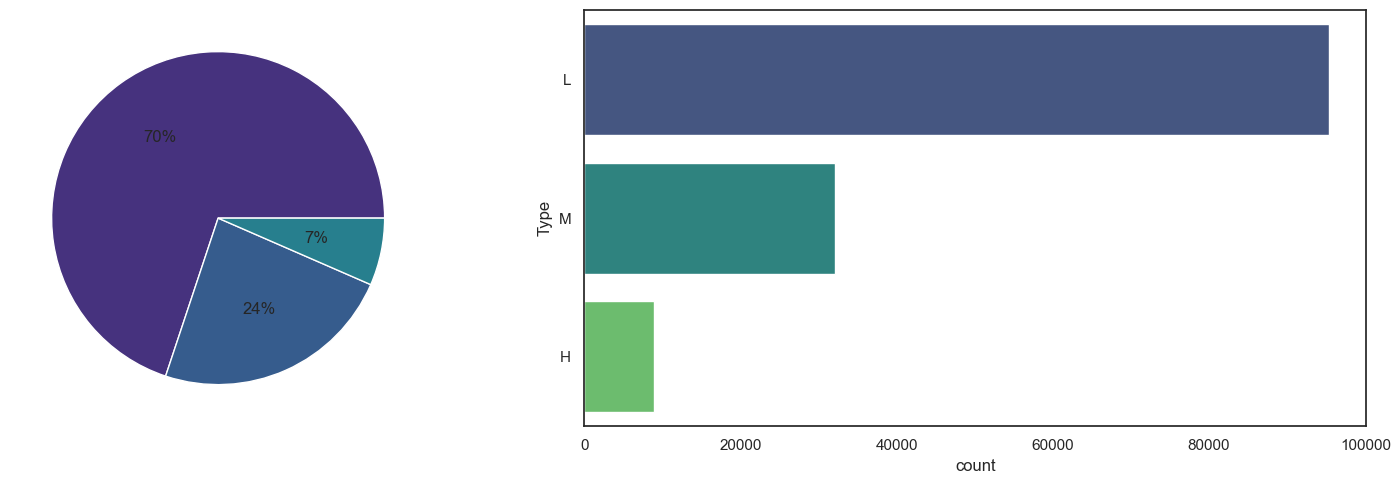

In [56]:
'''
첫 번째 그래프(ax[0])
"Type" 특성 값의 빈도를 기반으로 각 범주의 비율을 시각화
퍼센트 형식(autopct)으로 비율을 표시

두 번째 그래프(ax[1])
"Type" 특성 값의 빈도를 세어서 각 범주의 개수를 시각화
y축 레이블의 크기와 y축 눈금의 크기를 설정하고, x축 레이블의 크기와 y축 레이블은 None으로 설정
'''
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten() # ax 배열을 1차원으로 만들어 ax[0]과 ax[1]에 직접 참조를 얻음

ax[0].pie(
    df['Type'].value_counts(),
    autopct = '%1.f%%'
)

sns.countplot(data=df, y ='Type', ax=ax[1], palette='viridis', order=df['Type'].value_counts().index)

plt.tight_layout()

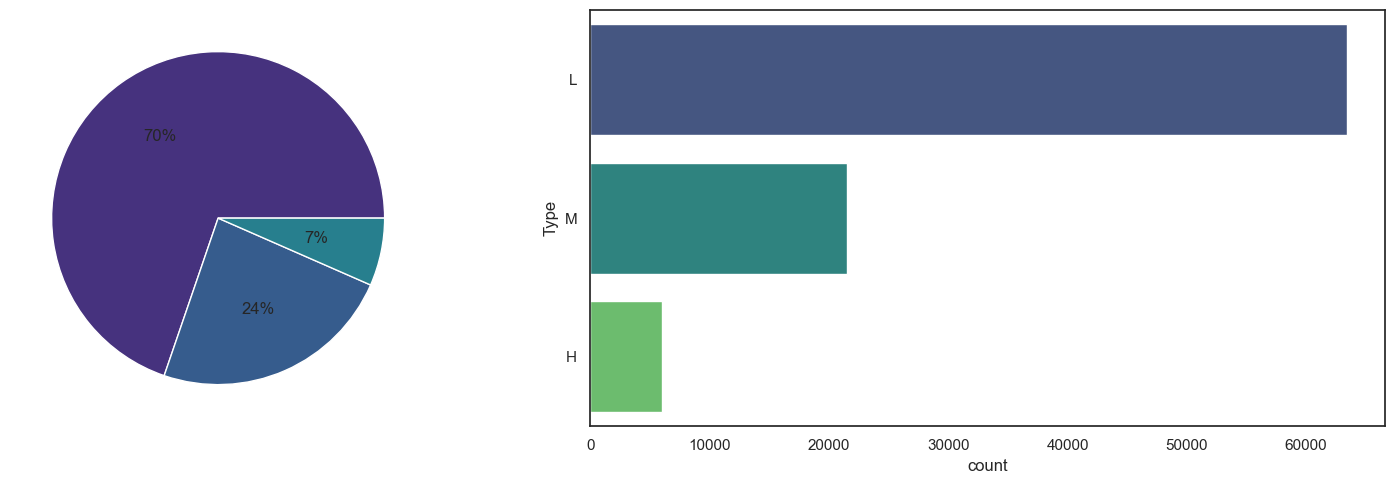

In [55]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten() # ax 배열을 1차원으로 만들어 ax[0]과 ax[1]에 직접 참조를 얻음

ax[0].pie(
    test['Type'].value_counts(),
    autopct = '%1.f%%'
)

sns.countplot(data=test, y ='Type', ax=ax[1], palette='viridis', order=test['Type'].value_counts().index)

plt.tight_layout()

In [57]:
def print_distribution(df, feature):
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax = ax.flatten()

    ax[0].pie(
        df[feature].value_counts(),
        autopct = '%1.f%%'
    )

    sns.countplot(data=df, y=feature, ax=ax[1], order=df[feature].value_counts().index)
    plt.tight_layout()

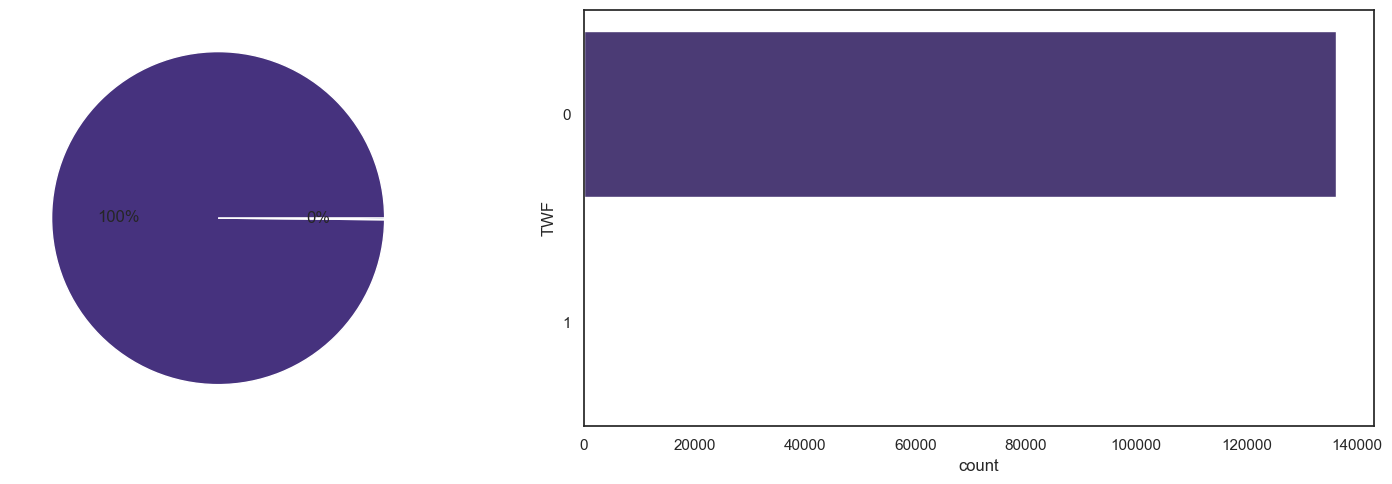

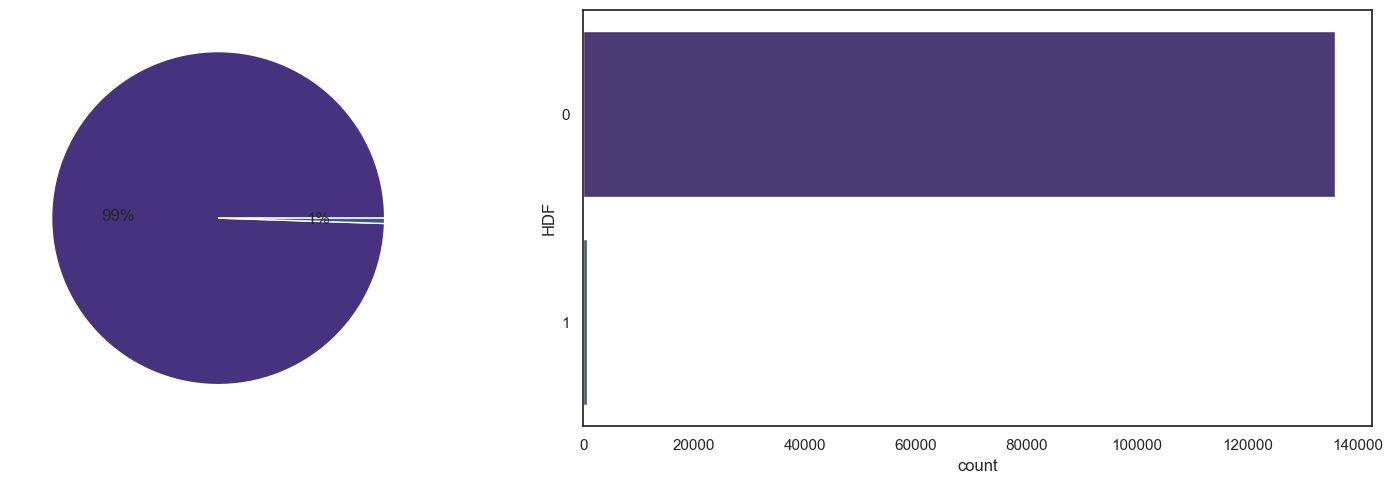

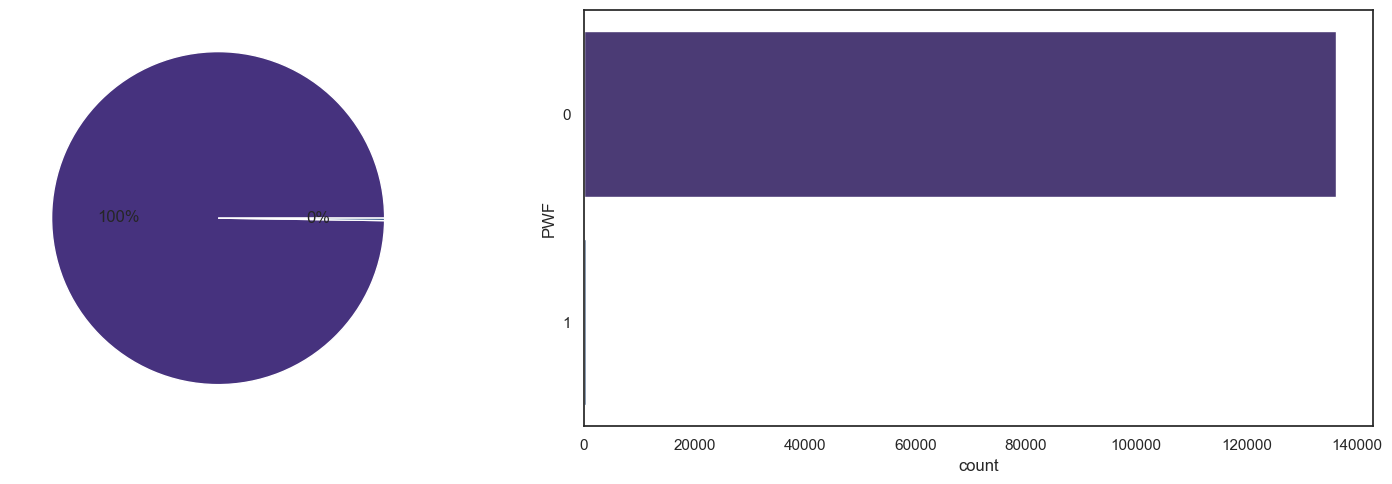

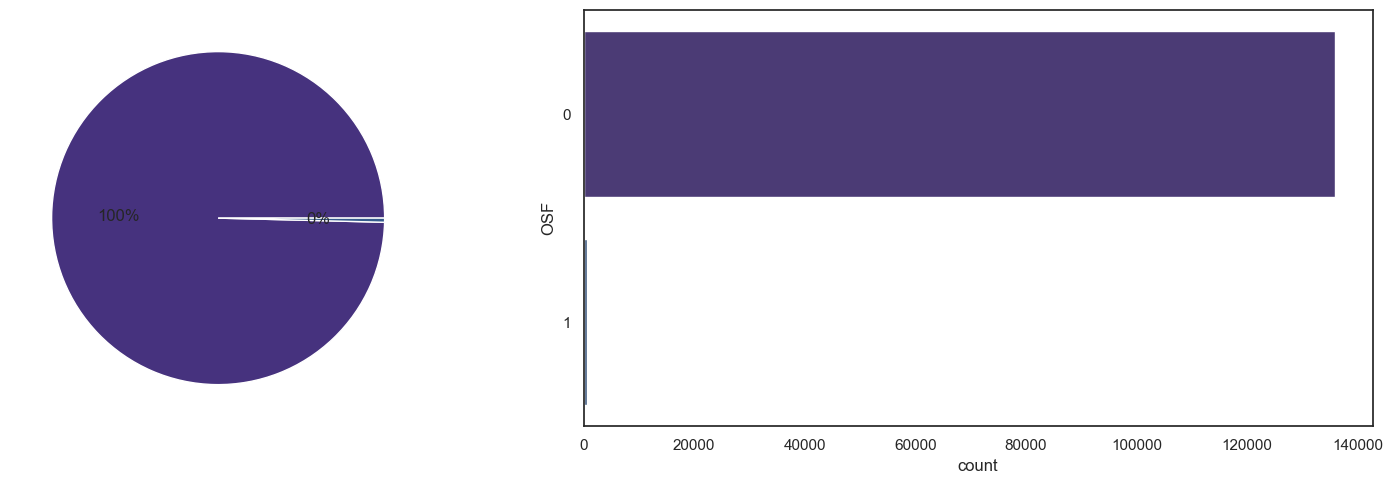

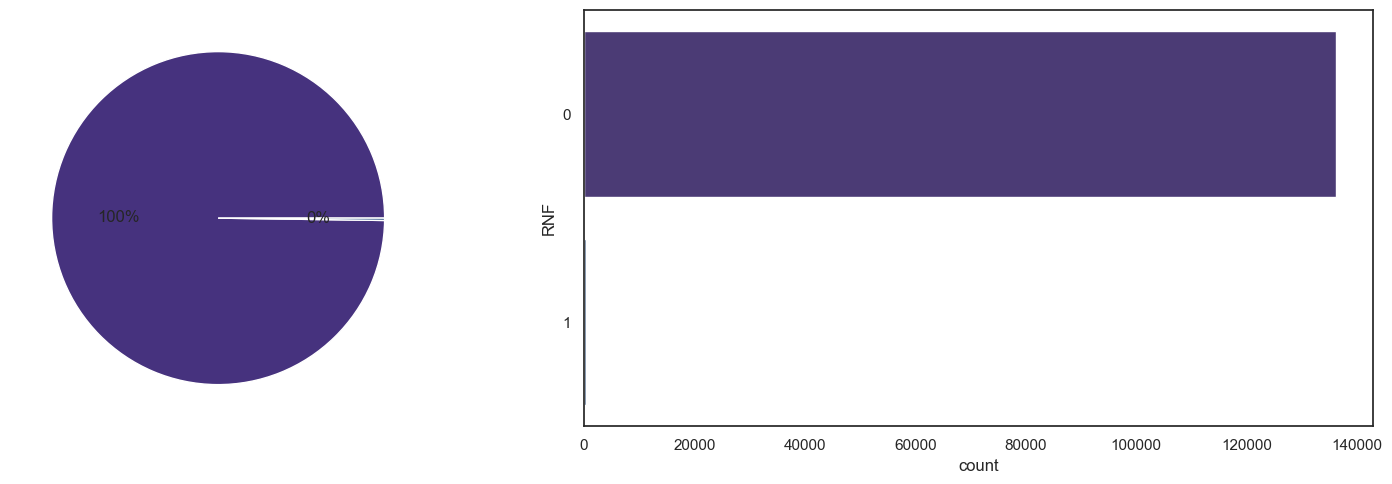

In [48]:
print_distribution(df, 'TWF')
print_distribution(df, 'HDF')
print_distribution(df, 'PWF')
print_distribution(df, 'OSF')
print_distribution(df, 'RNF')

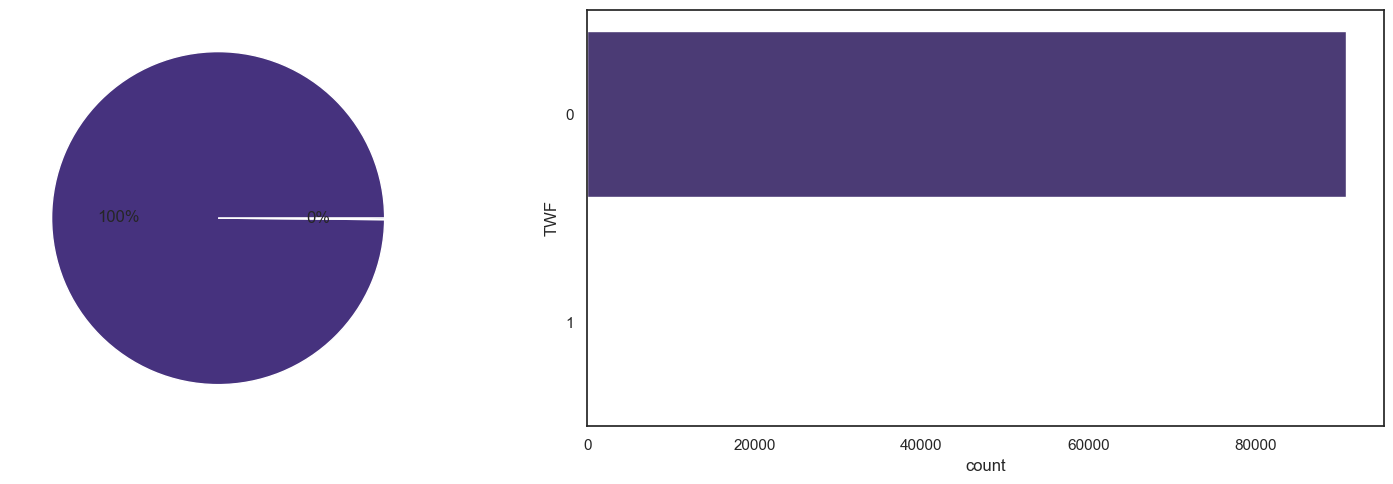

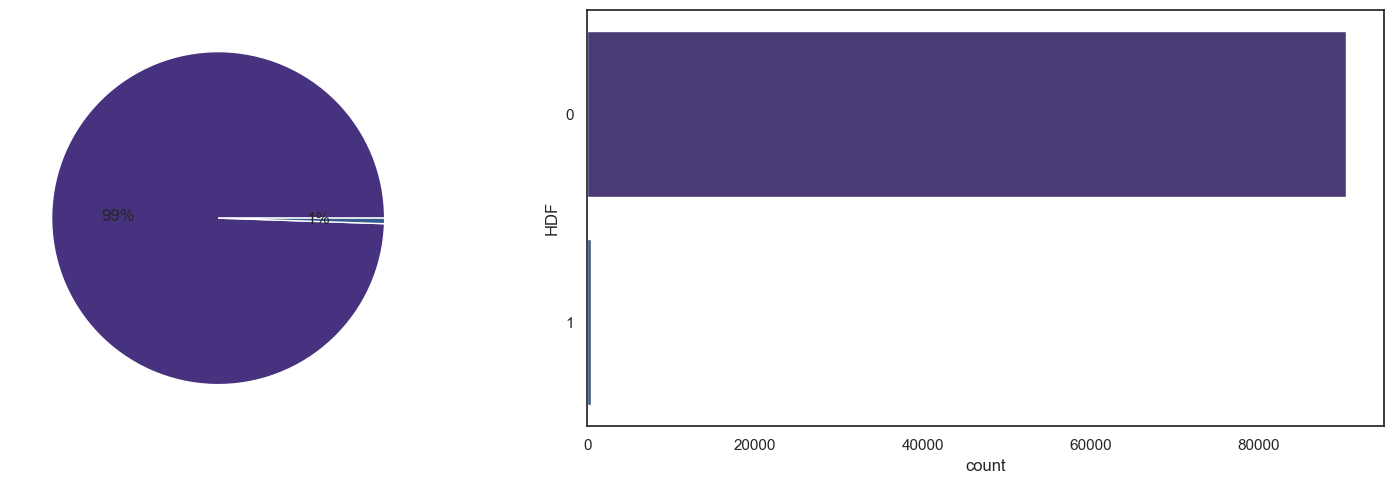

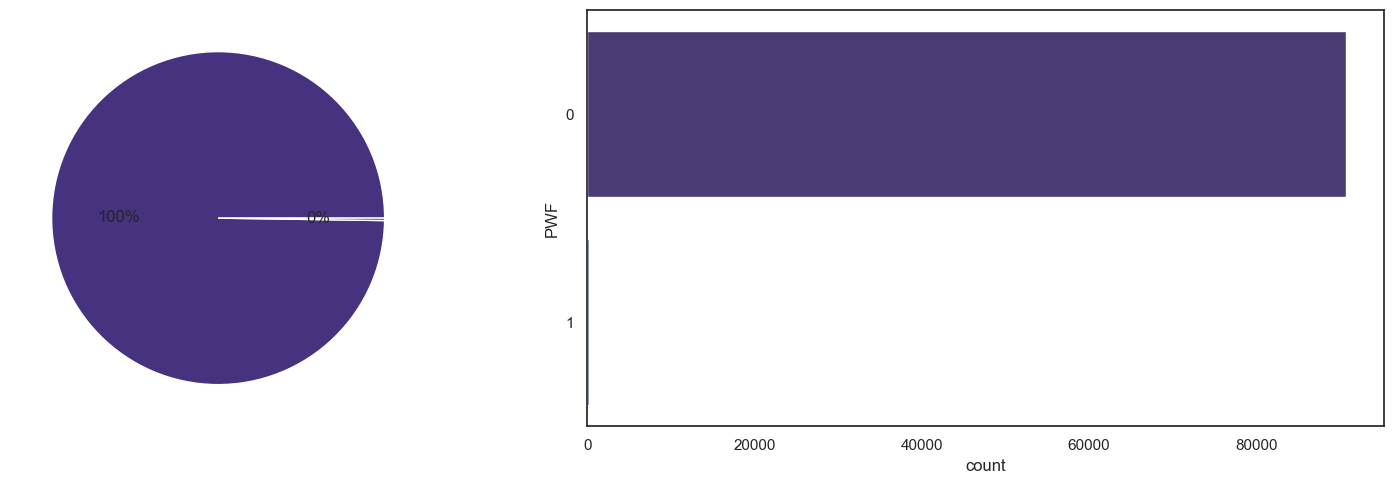

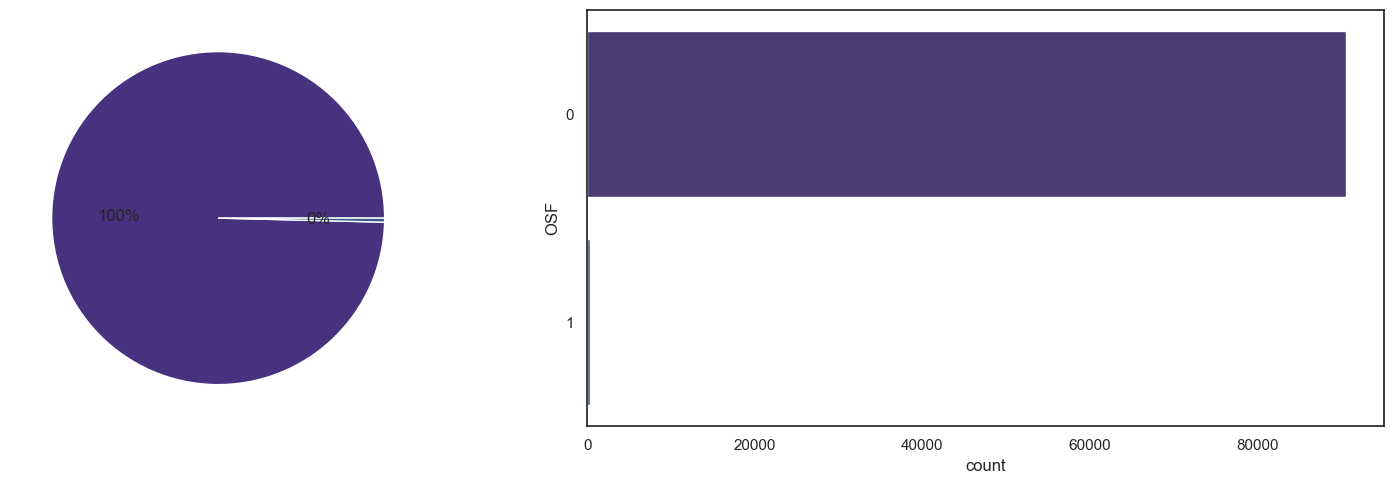

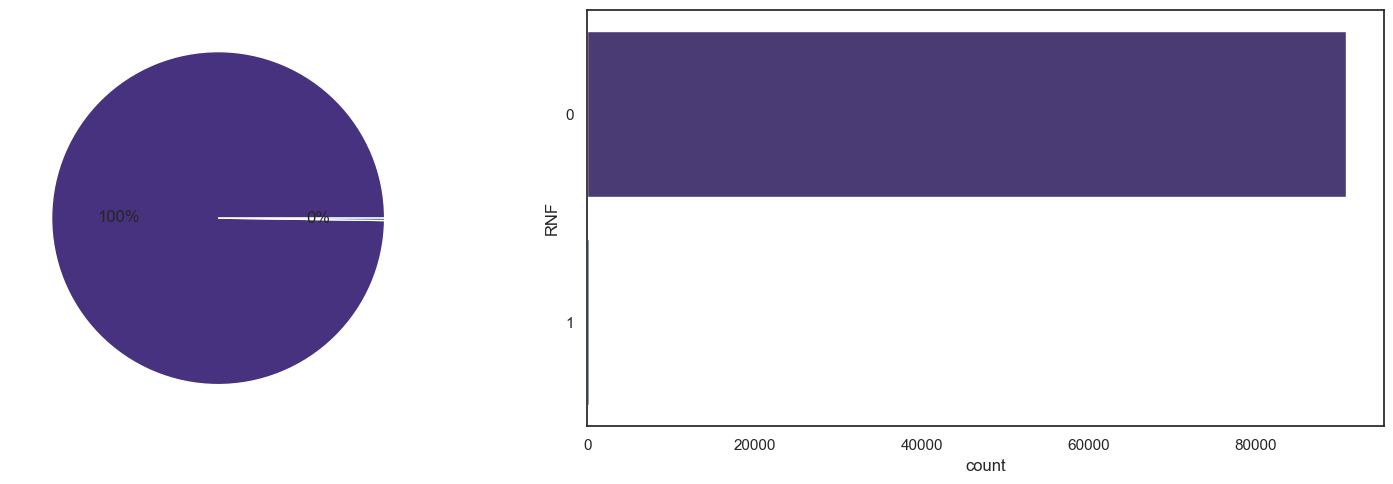

In [49]:
print_distribution(test, 'TWF')
print_distribution(test, 'HDF')
print_distribution(test, 'PWF')
print_distribution(test, 'OSF')
print_distribution(test, 'RNF')

In [ ]:
'''
주요 포인트:

학습 데이터와 테스트 데이터는 유사한 분포를 가지고 있습니다.
"Type" 특성은 불균형하며, L이 가장 많이 등장하고 H가 가장 적게 등장합니다.
나머지 범주형 특성은 거의 100-0 비율로 극단적으로 불균형합니다.
'''

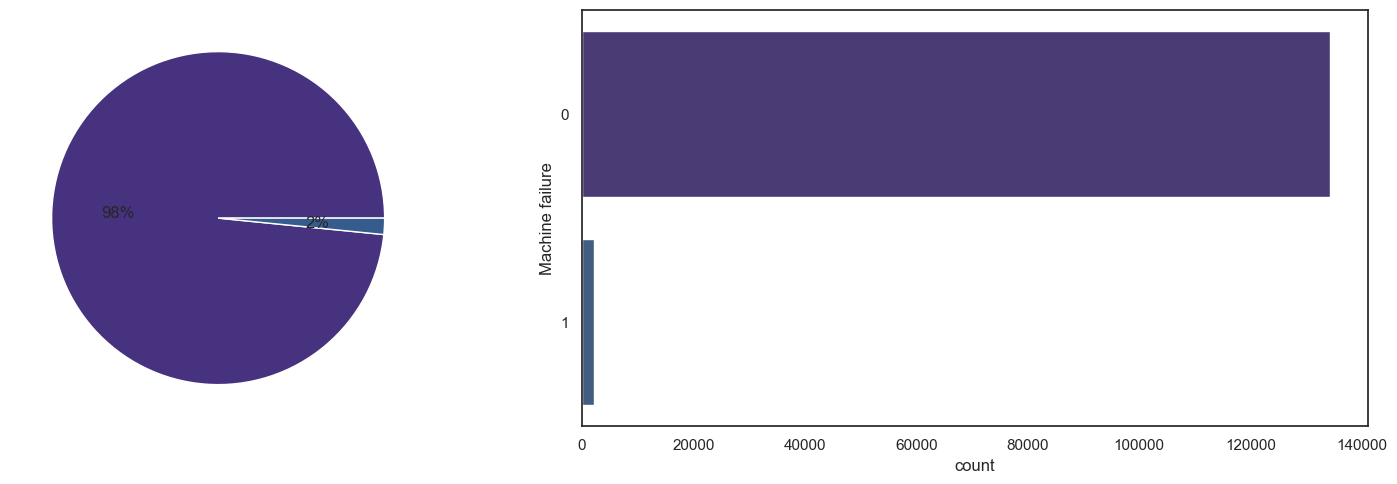

In [53]:
print_distribution(df, 'Machine failure')

In [65]:
def heatmap(df, label=None):
    corr = df.corr(method='spearman')
    mask = np.zeros_like(corr)
    plt.figure(figsize = (10, 10), dpi = 300)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, annot=True, annot_kws = {'size' : 7})
    plt.title(label)
    plt.show()

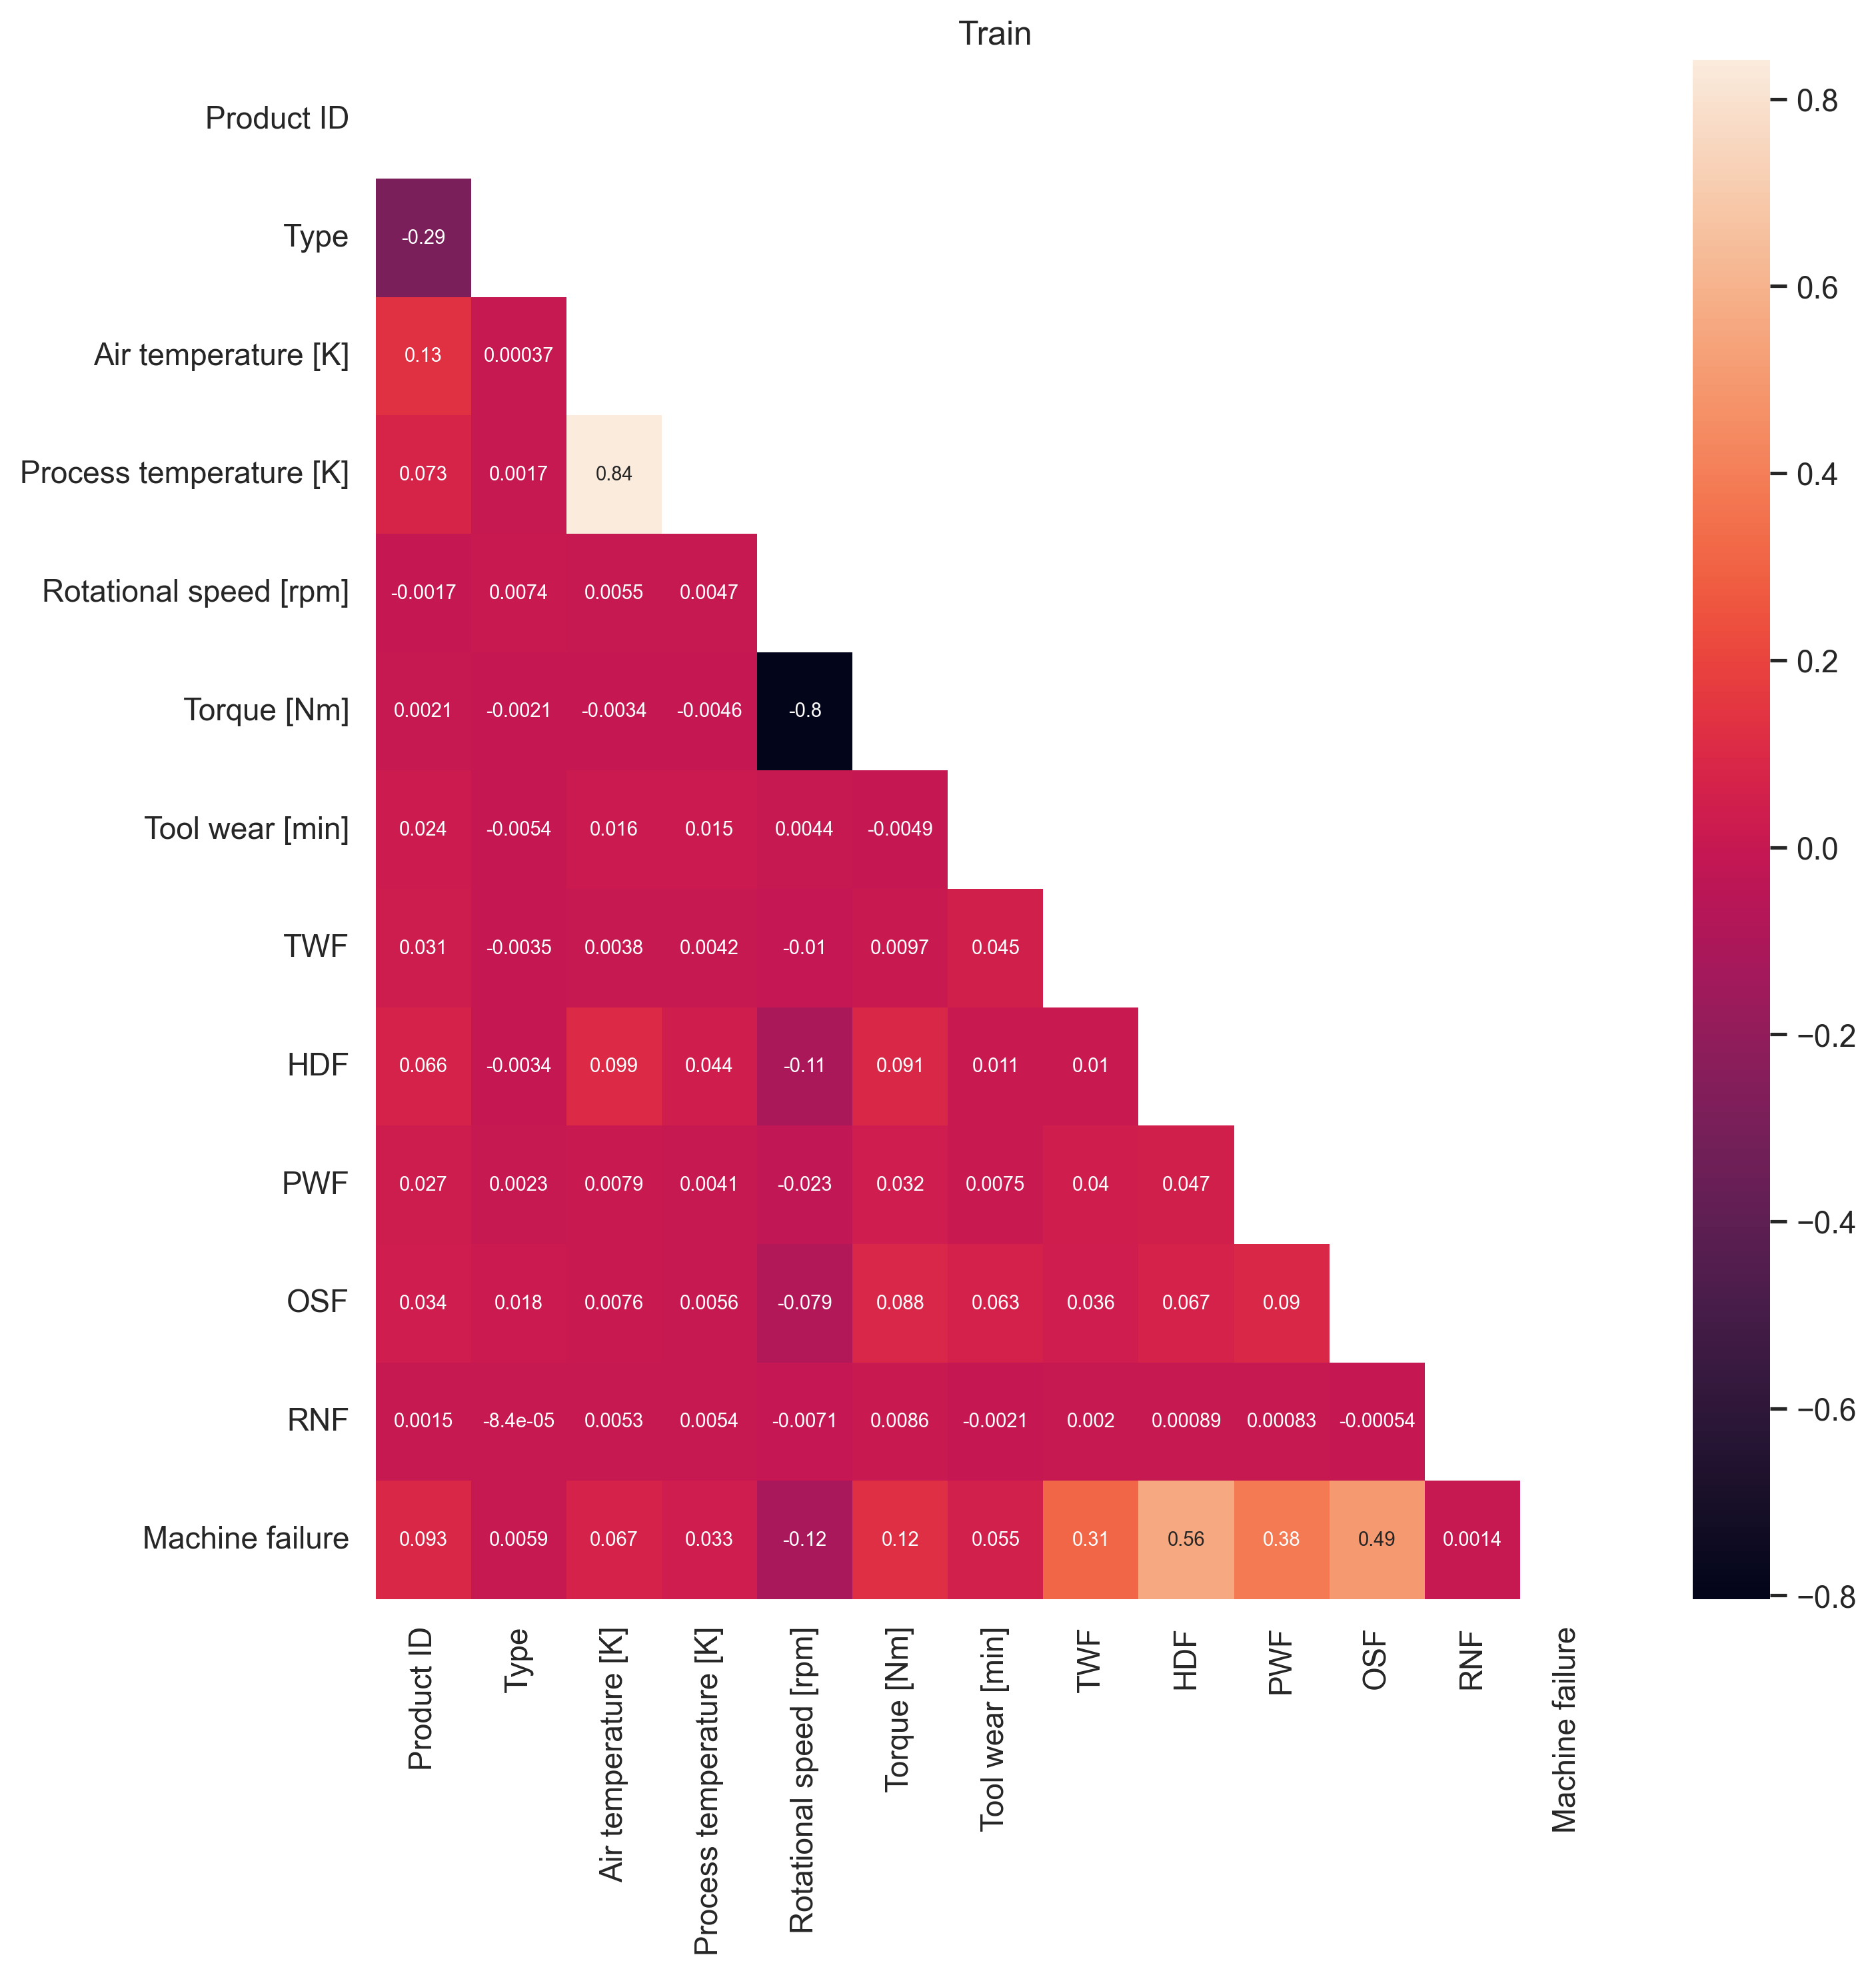

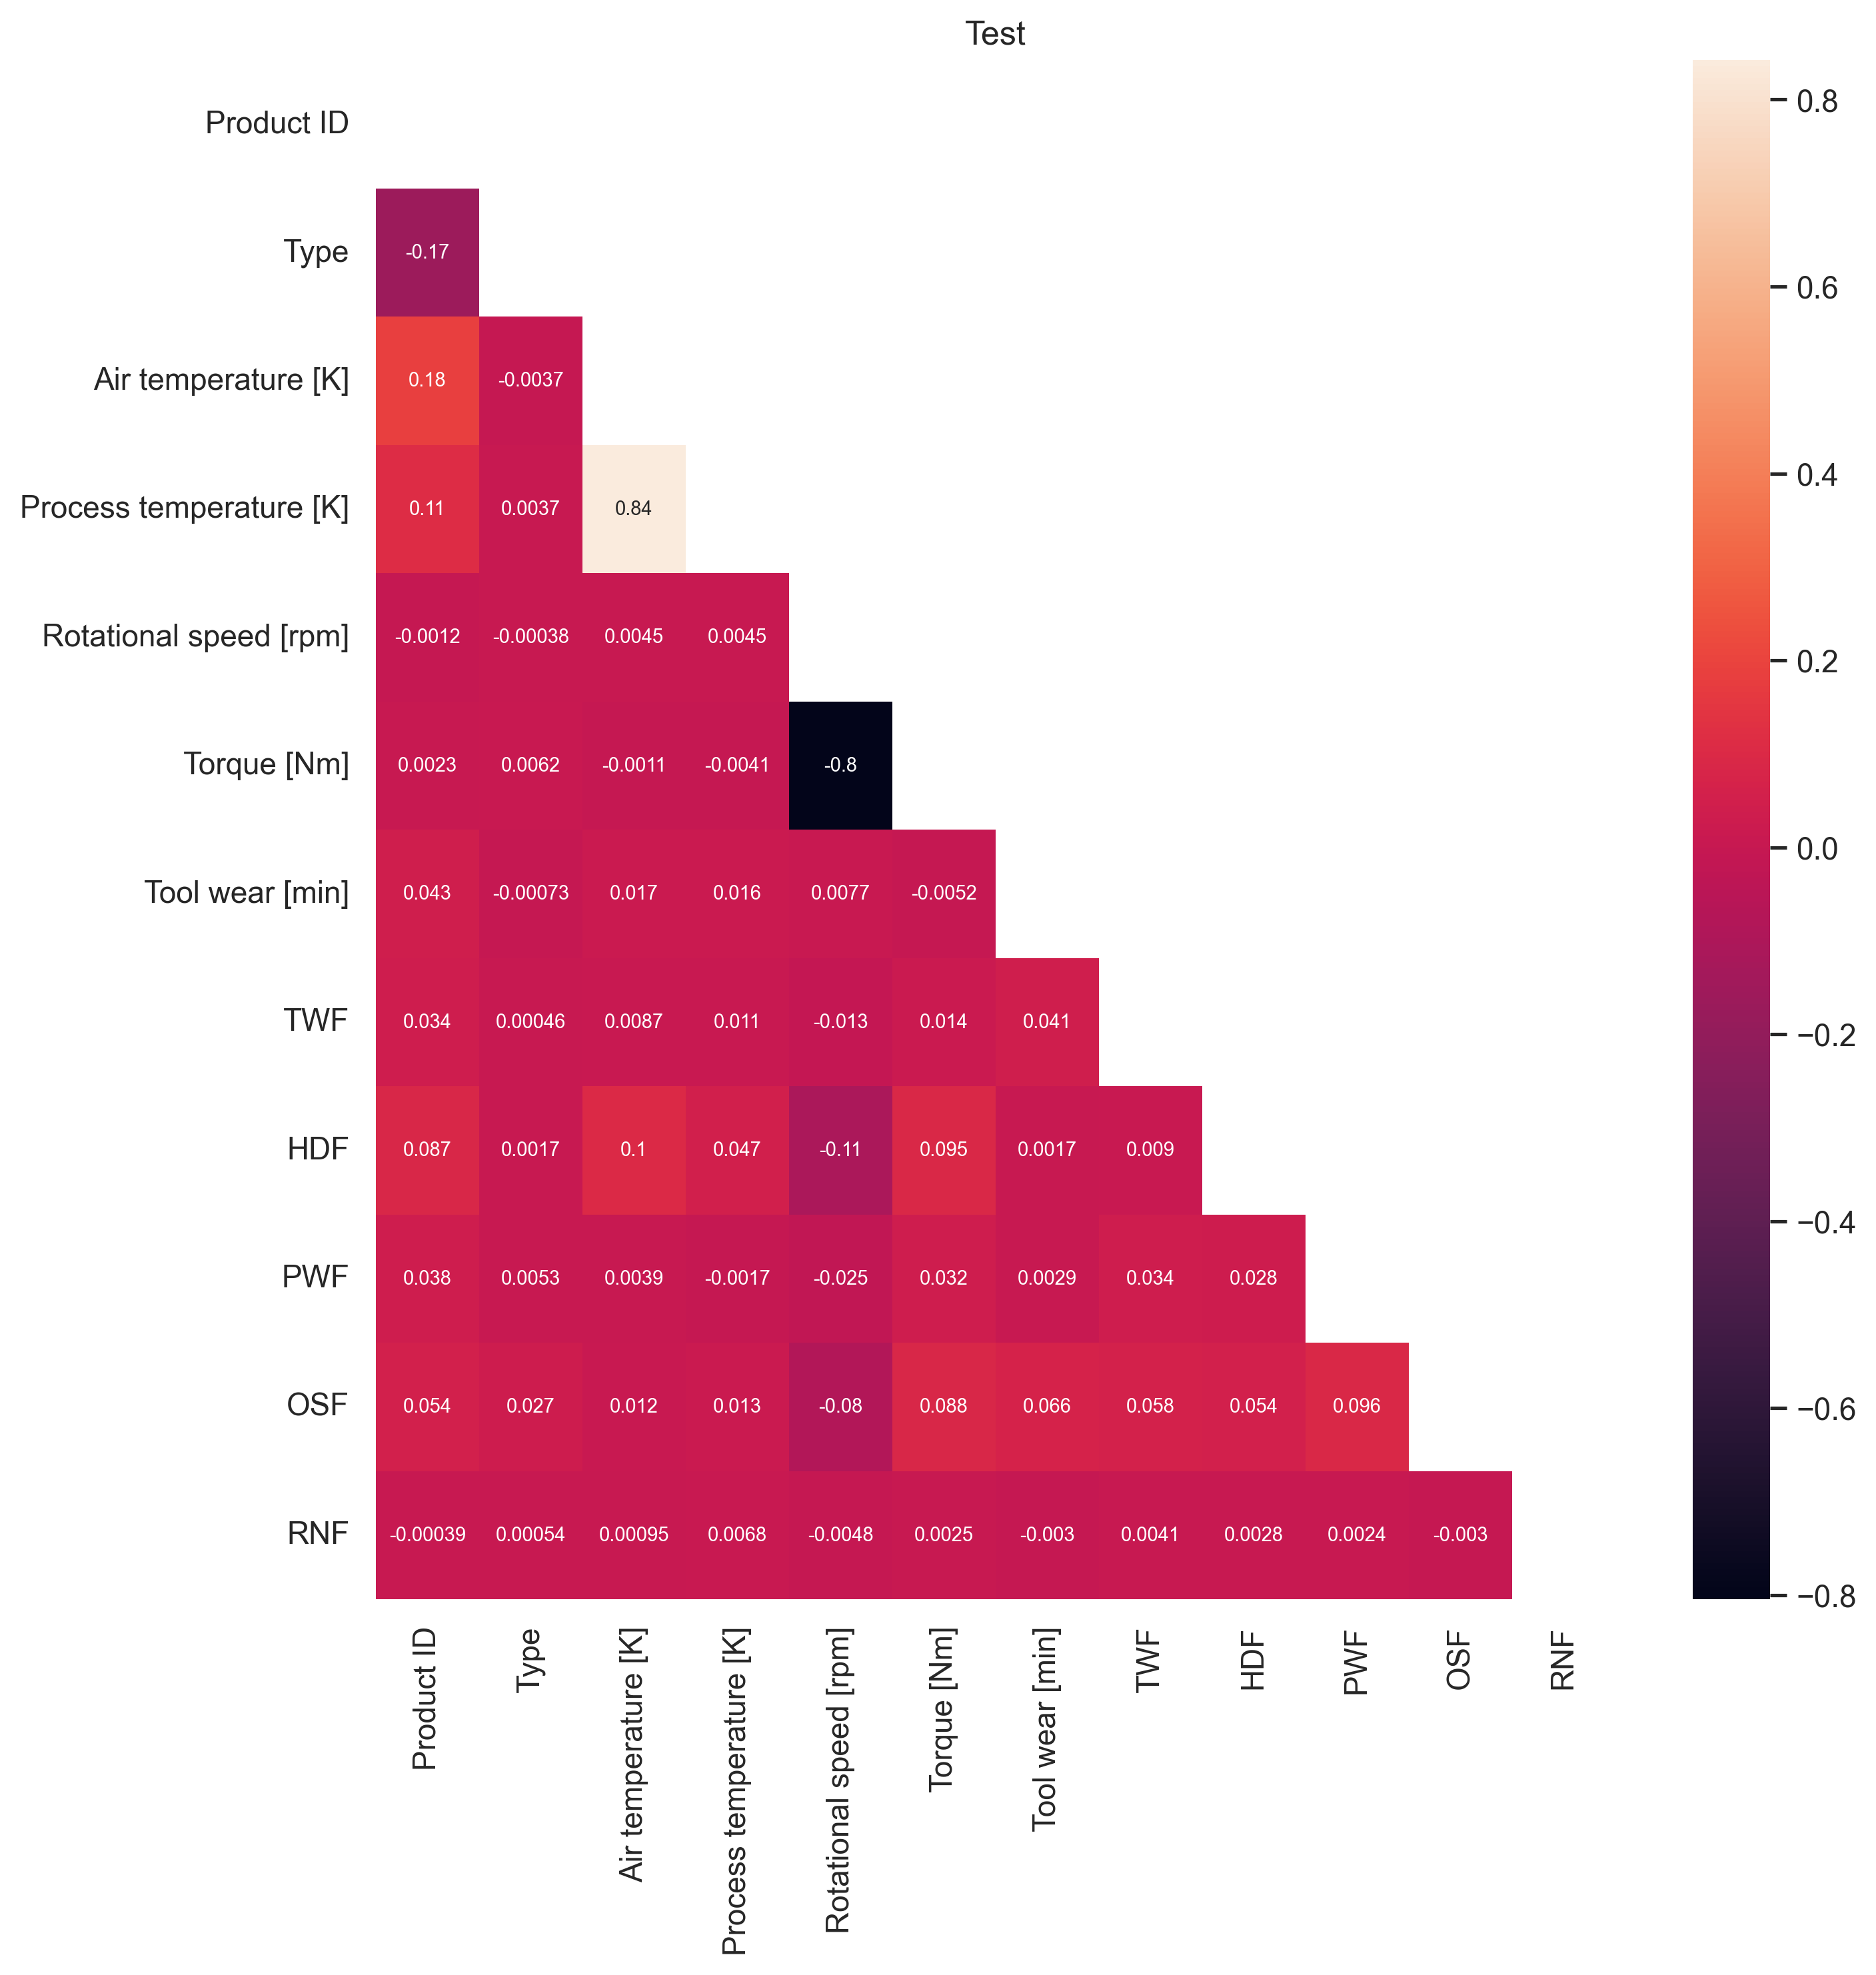

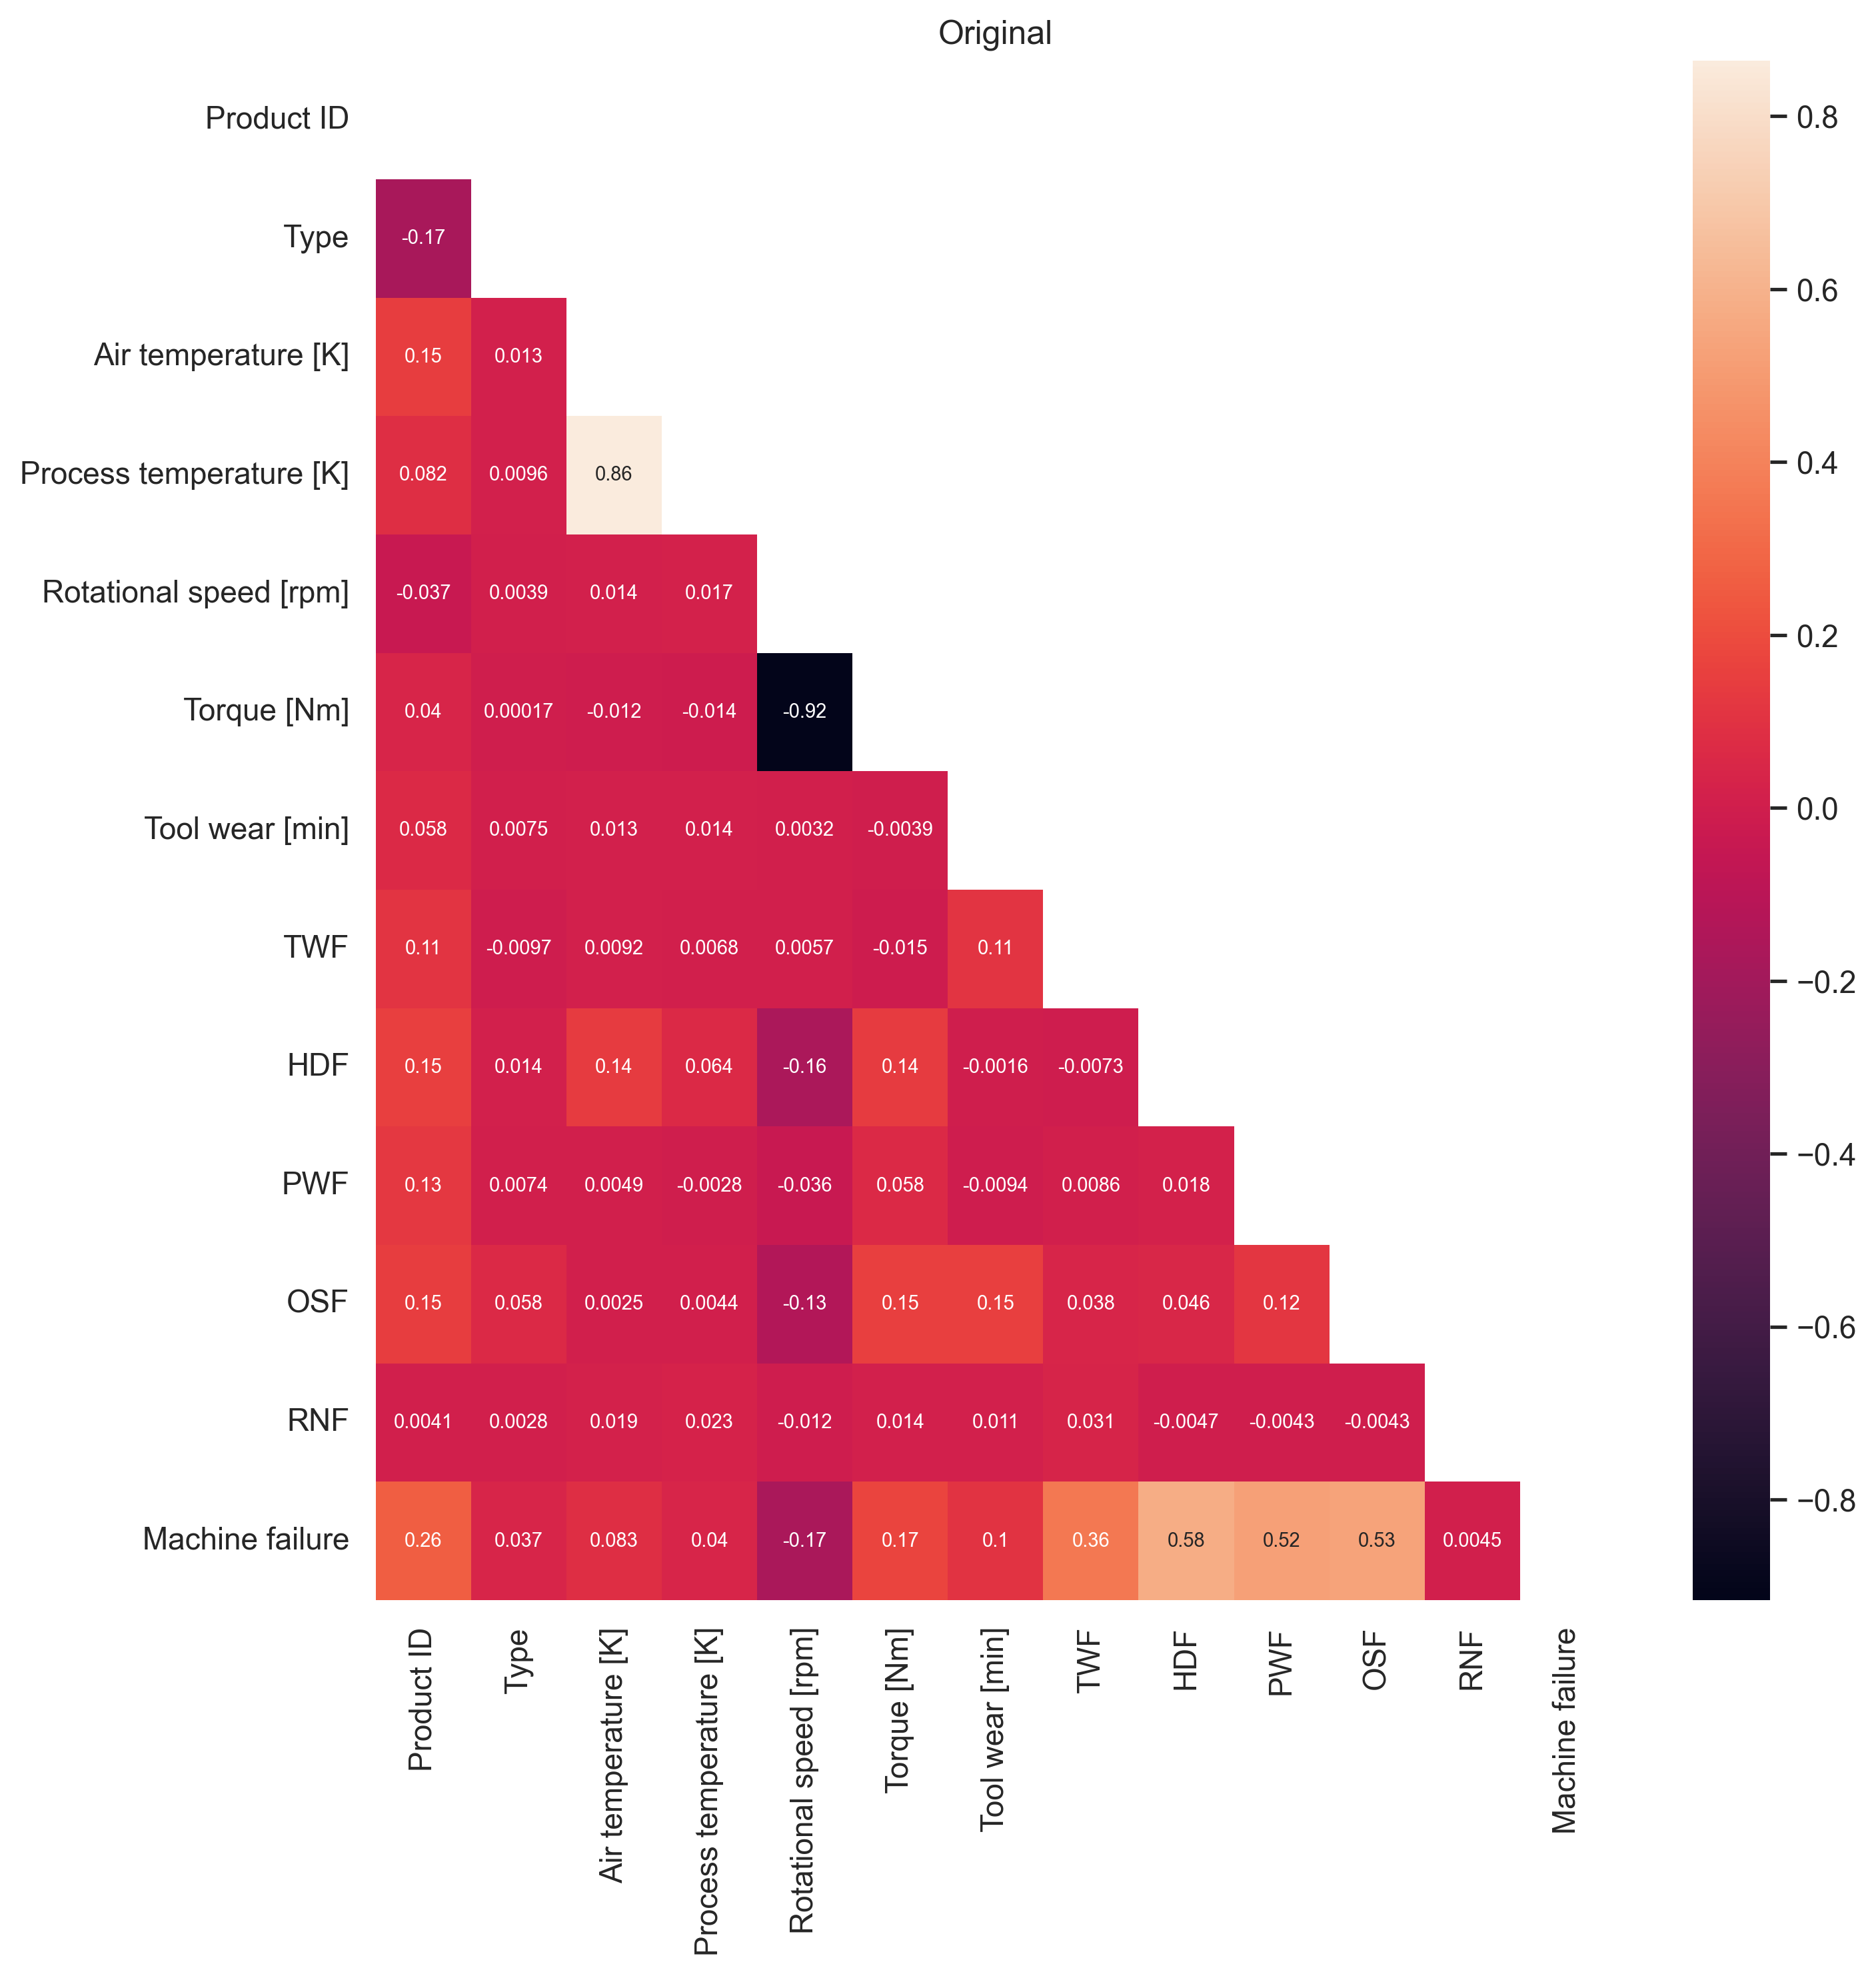

In [67]:
heatmap(encoded_train, 'Train')
heatmap(encoded_test, 'Test')
heatmap(encoded_machine_failure, 'Original')

In [ ]:
'''
주요 포인트:

공정 온도(Process temperature)와 공기 온도(air temperature)는 강한 양의 상관관계를 가지고 있습니다.
토크(Torque)와 회전 속도(rotational speed)는 강한 음의 상관관계를 가지고 있습니다.
기계 고장은 RNF를 제외한 대부분의 이진 범주형 특성과 중간 정도의 상관관계를 가지고 있습니다.
제품 ID와 유형은 강한 양의 상관관계를 가지고 있습니다.
나머지 특성들은 거의 상관관계가 없습니다.
'''

In [76]:
'''
변수들 간의 유사성 또는 거리를 계산하고 클러스터링 결과를 덴드로그램으로 시각화

squareform 함수는 상관계수 행렬을 거리 행렬로 변환
linkage 함수는 계산된 거리 행렬을 이용하여 클러스터링을 수행하고 클러스터들을 계층적으로 연결
'''
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

def distance(df, label=''):
    corr = df.corr(method='spearman')
    dist_linkage = linkage(squareform(1-abs(corr)), 'complete')
    plt.figure(figsize=(10, 8), dpi=300)
    dendro=dendrogram(dist_linkage, labels=df.columns, leaf_rotation=90)
    plt.title(label)
    plt.show()

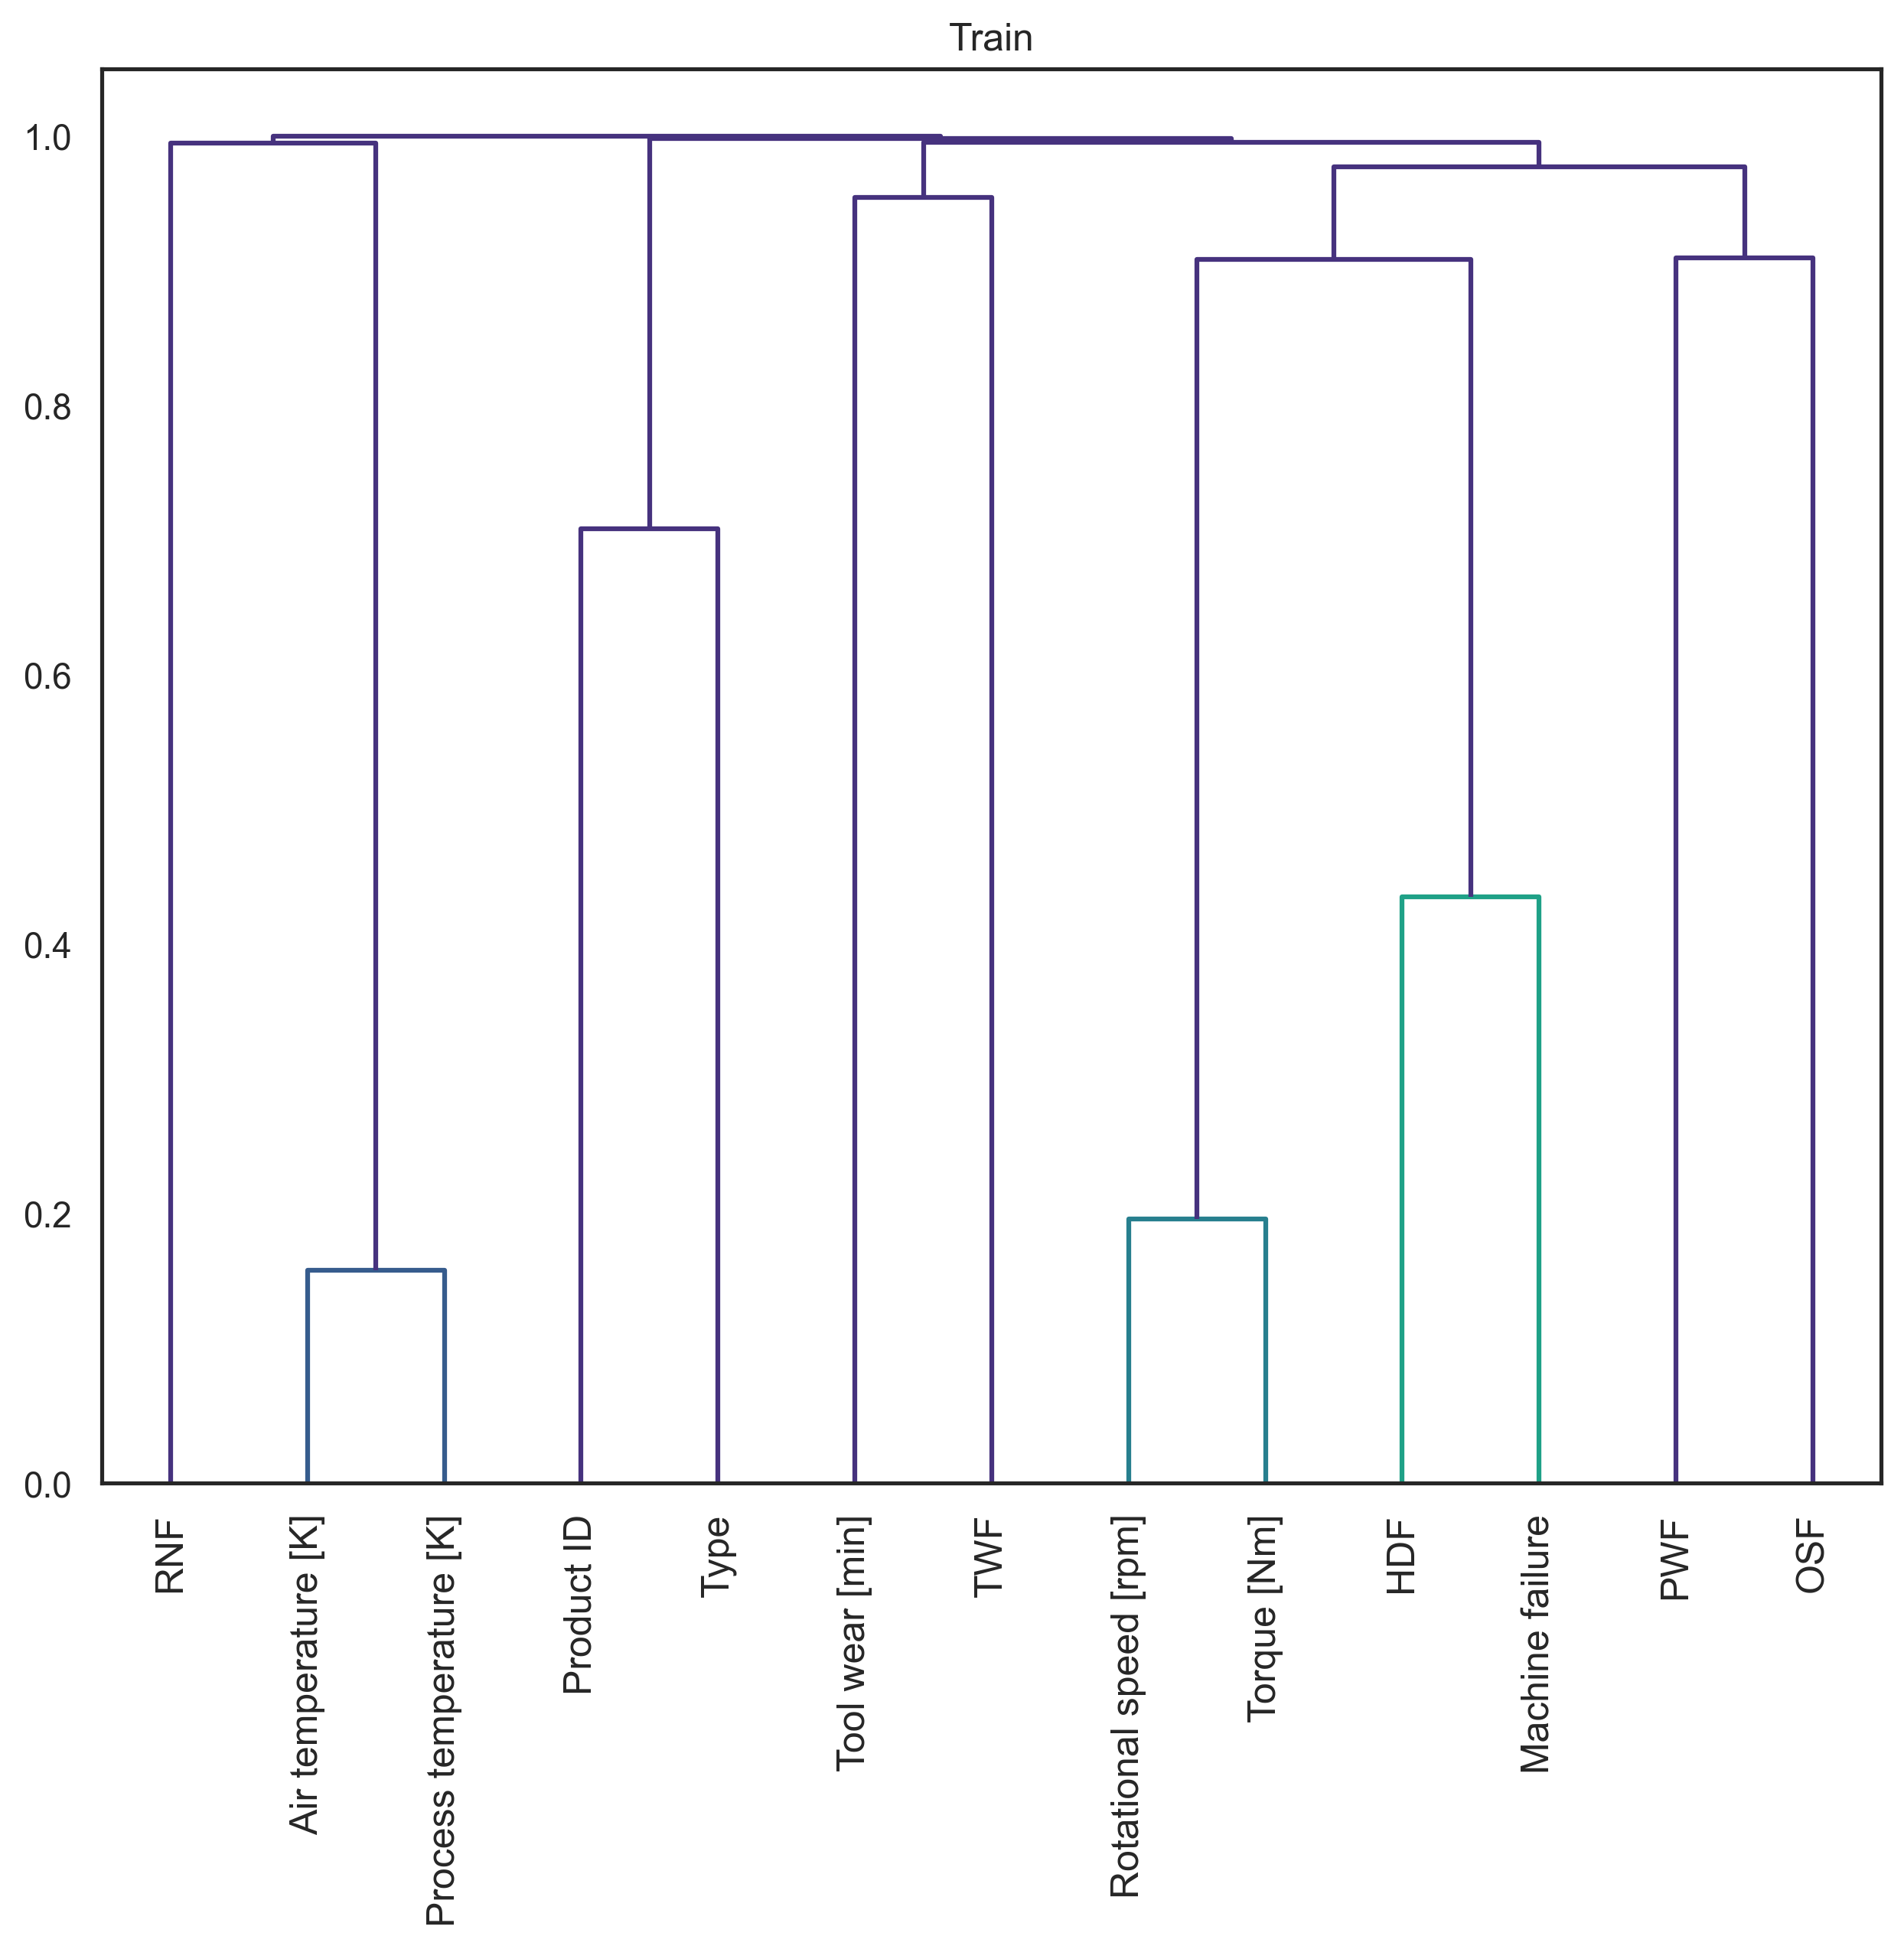

In [77]:
distance(encoded_train, 'Train')

## Reference
- [kaggle notebook](https://www.kaggle.com/code/iqbalsyahakbar/ps3e17-eda-and-ensemble-for-starters)